<a href="https://colab.research.google.com/github/cmnemoi/ProjetDataScienceLPSID/blob/main/src/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Data Science - Nettoyage des données
### Enzo Risbetz et Charles-Meldhine MADI MNEMOI


Cette étape consiste à télécharger les données et ensuite les nettoyer, à supprimer les colonnes indésirables, à convertir certaine variable si nécessaire. 

 ### Méthode d’extraction des données :

Nous avons téléchargé le fichier Excel provenant du site : https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page Les données sont celle du mois de Mai pour l’année 2020.


### Importation des packages et des données

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/cmnemoi/ProjetDataScienceLPSID/data_cleaning/data/data.csv")

/tmp/ipykernel_14871/3914182881.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("https://raw.githubusercontent.com/cmnemoi/ProjetDataScienceLPSID/data_cleaning/data/data.csv")


In [6]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [7]:
data.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-05-01 00:02:28,2020-05-01 00:18:07,1.0,0.0,1.0,N,234,256,1.0,12.2,3.0,0.5,2.4,0.0,0.3,18.4,2.5
1,1.0,2020-05-01 00:23:21,2020-05-01 00:26:01,2.0,0.4,1.0,N,264,264,1.0,4.0,0.5,0.5,0.5,0.0,0.3,5.8,0.0
2,1.0,2020-05-01 00:54:58,2020-05-01 00:57:11,1.0,0.3,1.0,N,264,264,2.0,3.5,0.5,0.5,0.0,0.0,0.3,4.8,0.0
3,1.0,2020-05-01 00:07:10,2020-05-01 00:12:46,1.0,1.7,1.0,N,107,229,2.0,7.0,3.0,0.5,0.0,0.0,0.3,10.8,2.5
4,1.0,2020-05-01 00:55:47,2020-05-01 01:01:54,0.0,0.9,1.0,N,237,262,1.0,6.0,3.0,0.5,1.2,0.0,0.3,11.0,2.5


On remarque notamment à l'aide du dictionnaire des variables que la variable à prédire `Total_amount` est la somme des variables suivantes : `fare_amount`, `extra`, `mta_tax`, `tip_amount`, `tolls_amount`, `improvement_surcharge` et `congestion_surcharge`.

De plus, `RatecodeID` est une variable codant le type de tarif à appliquer.

Introduire ces variables dans notre modèle de prédiction n'est pas très pertinent, on les retire donc.

In [8]:
data = data.drop(["fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "RatecodeID"], axis=1)

On remarque également les variables `PULocationID` et `DOLocationID`, qui sont les zones de début et de fin de course. 
Utilisons un dataset qui répertorie les libellés de ces zones pour les fusionner avec notre dataset :

In [9]:
TLC_lookup_zones = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv")
TLC_lookup_zones["PULocationID"] = TLC_lookup_zones["LocationID"]
TLC_lookup_zones["DOLocationID"] = TLC_lookup_zones["LocationID"]
TLC_lookup_zones.head()

,LocationID,Borough,Zone,service_zone,PULocationID,DOLocationID
0,1,EWR,Newark Airport,EWR,1,1
1,2,Queens,Jamaica Bay,Boro Zone,2,2
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,3
3,4,Manhattan,Alphabet City,Yellow Zone,4,4
4,5,Staten Island,Arden Heights,Boro Zone,5,5


In [10]:
#on fait des inner join
data = pd.merge(data, TLC_lookup_zones[["PULocationID", "Zone"]], on="PULocationID", how="inner")
data["PULocationLabel"] = data["Zone"]
data.head()
data = data.drop("Zone", axis=1)
data = pd.merge(data, TLC_lookup_zones[["DOLocationID", "Zone"]], on="DOLocationID", how="inner")
data["DOLocationLabel"] = data["Zone"]
data = data.drop("Zone", axis=1)
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
0,1.0,2020-05-01 00:02:28,2020-05-01 00:18:07,1.0,0.00,N,234,256,1.0,18.40,Union Sq,Williamsburg (South Side)
1,1.0,2020-05-01 16:25:12,2020-05-01 16:45:33,1.0,4.30,N,234,256,1.0,23.98,Union Sq,Williamsburg (South Side)
2,2.0,2020-05-06 12:58:26,2020-05-06 13:16:11,5.0,3.89,N,234,256,1.0,22.56,Union Sq,Williamsburg (South Side)
3,1.0,2020-05-06 17:22:10,2020-05-06 17:38:17,1.0,3.80,N,234,256,1.0,21.80,Union Sq,Williamsburg (South Side)
4,2.0,2020-05-07 13:03:37,2020-05-07 13:21:53,2.0,4.97,N,234,256,1.0,24.36,Union Sq,Williamsburg (South Side)


In [11]:
data.shape

(348371, 12)

### Retrait des valeurs manquantes

In [12]:
data.isna().sum()

VendorID                 58891
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          58891
trip_distance                0
store_and_fwd_flag       58891
PULocationID                 0
DOLocationID                 0
payment_type             58891
total_amount                 0
PULocationLabel            619
DOLocationLabel           2269
dtype: int64

On observe des valeurs manquantes dans `VendorID`, `passenger_count`, `store_and_fwd_flag` et `payment_type`. Ces individus ne représentant que 15% du dataset, on décide de les supprimer car il nous restera toujours assez de données pour travailler par la suite.

In [13]:
data = data.dropna(subset=["VendorID", "passenger_count", "store_and_fwd_flag", "payment_type"])

In [14]:
data.shape

(289480, 12)

### Identification des valeurs aberrantes

In [15]:
for column in data.columns:
  try:
      print(f"Valeurs uniques dans {column} : {np.sort(data[column].unique())}")
  except Exception as e:
      continue

Valeurs uniques dans VendorID : [1. 2.]
Valeurs uniques dans tpep_pickup_datetime : ['2008-12-31 23:05:47' '2009-01-01 00:57:36' '2009-01-01 02:19:49' ...
 '2020-11-01 15:15:05' '2020-11-01 15:26:33' '2020-11-01 15:41:04']
Valeurs uniques dans tpep_dropoff_datetime : ['2008-12-31 23:33:33' '2009-01-01 01:05:48' '2009-01-01 02:23:35' ...
 '2020-11-01 15:23:18' '2020-11-01 15:39:04' '2020-11-01 15:57:02']
Valeurs uniques dans passenger_count : [0. 1. 2. 3. 4. 5. 6. 8. 9.]
Valeurs uniques dans trip_distance : [0.000000e+00 1.000000e-02 2.000000e-02 ... 2.380000e+02 3.051000e+02
 1.097355e+04]
Valeurs uniques dans store_and_fwd_flag : ['N' 'Y']
Valeurs uniques dans PULocationID : [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  28  29  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  8

On observe quelques valeurs intriguantes, voyons en détail :


Pour `tpep_pickup_datetime` et `tpep_dropoff_datetime`, on observe que certaines valeurs ne correspondent pas au mois de Mai 2020 comme convenu dans le périmètre de l'étude. On les retire, d'autant plus qu'elles ne reprédentent que 82 individus du dataset au maximum : nous aurons toujours assez de données pour continuer.

In [16]:
data[~data["tpep_pickup_datetime"].str.contains("2020-05")].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
20223,2.0,2020-07-18 00:38:57,2020-07-18 00:55:00,1.0,5.51,N,142,244,2.0,23.30,Lincoln Square East,Washington Heights South
49428,2.0,2020-04-30 18:18:23,2020-05-01 17:30:12,1.0,1.07,N,249,249,2.0,11.80,West Village,West Village
71920,2.0,2020-11-01 15:41:04,2020-11-01 15:57:02,1.0,6.21,N,152,68,2.0,24.30,Manhattanville,East Chelsea
74883,2.0,2020-06-05 08:14:36,2020-06-05 08:16:56,1.0,0.48,N,68,68,2.0,6.80,East Chelsea,East Chelsea
85488,2.0,2020-06-05 08:37:44,2020-06-05 08:44:38,1.0,2.02,N,43,170,1.0,14.16,Central Park,Murray Hill


In [17]:
print("Trajets hors mai 2020 : {}".format(data[~data["tpep_pickup_datetime"].str.contains("2020-05")].shape[0]))

Trajets hors mai 2020 : 23


In [18]:
print("Trajets hors mai 2020 : {}".format(data[~data["tpep_dropoff_datetime"].str.contains("2020-05")].shape[0]))

Trajets hors mai 2020 : 69


In [19]:
data = data[data["tpep_pickup_datetime"].str.contains("2020-05")]
data = data[data["tpep_dropoff_datetime"].str.contains("2020-05")]

Pour `passenger_count`, les valeurs 8 et 9 semblent aberrantes. En effet, difficile d'imaginer un taxi et une limousine avec 8 ou 9 passagers. D'après nos recherches, le maximum de passagers autorisés dans un taxi-limousine est de 6 personnes. 

Ces valeurs ne composant que deux individus de notre dataset, on les retire en gardant la variable.

In [20]:
data[data["passenger_count"] >= 8]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
278583,2.0,2020-05-31 20:53:17,2020-05-31 20:53:19,8.0,0.0,N,116,116,1.0,11.00,Hamilton Heights,Hamilton Heights
290971,2.0,2020-05-20 06:42:42,2020-05-20 06:42:48,9.0,0.0,N,264,264,1.0,11.76,NV,NV


In [21]:
data = data[data["passenger_count"] < 8]

In [22]:
data[data["passenger_count"] < 1]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
11,1.0,2020-05-25 16:24:04,2020-05-25 16:38:44,0.0,3.4,N,234,256,3.0,16.80,Union Sq,Williamsburg (South Side)
81,1.0,2020-05-29 18:02:31,2020-05-29 18:13:52,0.0,2.6,N,79,256,1.0,17.14,East Village,Williamsburg (South Side)
86,1.0,2020-05-21 10:16:03,2020-05-21 10:44:47,0.0,9.3,N,151,256,2.0,34.30,Manhattan Valley,Williamsburg (South Side)
110,1.0,2020-05-23 19:31:42,2020-05-23 19:50:29,0.0,8.4,N,263,256,1.0,28.80,Yorkville West,Williamsburg (South Side)
132,1.0,2020-05-29 00:30:58,2020-05-29 00:48:20,0.0,10.7,N,75,256,2.0,36.92,East Harlem South,Williamsburg (South Side)
...,...,...,...,...,...,...,...,...,...,...,...,...
348077,1.0,2020-05-13 05:21:37,2020-05-13 05:21:40,0.0,0.0,N,207,207,3.0,3.80,Saint Michaels Cemetery/Woodside,Saint Michaels Cemetery/Woodside
348078,1.0,2020-05-13 06:36:45,2020-05-13 06:37:04,0.0,0.0,Y,207,207,2.0,0.30,Saint Michaels Cemetery/Woodside,Saint Michaels Cemetery/Woodside
348096,1.0,2020-05-26 12:18:13,2020-05-26 12:19:34,0.0,0.0,N,207,207,2.0,3.80,Saint Michaels Cemetery/Woodside,Saint Michaels Cemetery/Woodside
348105,1.0,2020-05-30 06:48:04,2020-05-30 06:52:05,0.0,1.3,N,129,207,2.0,6.80,Jackson Heights,Saint Michaels Cemetery/Woodside


On observe également 9605 lignes avec 0 passagers. 

Elles représentent 3% de notre dataset, on peut donc les supprimer en conservant la variable.

In [23]:
data = data[data["passenger_count"] > 0]

Examinons `trip_distance` :


In [24]:
data["trip_distance"].describe()

count    279802.000000
mean          2.737067
std          21.037388
min           0.000000
25%           0.950000
50%           1.700000
75%           3.100000
max       10973.550000
Name: trip_distance, dtype: float64

<AxesSubplot:ylabel='trip_distance'>

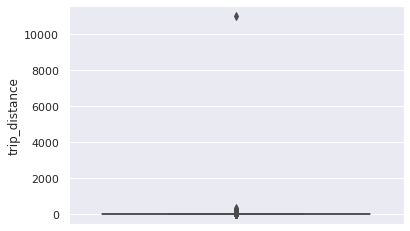

In [25]:
sns.boxplot(y=data["trip_distance"])

On observe d'une part des trajets de 0 miles, ce qui est impossible à priori.

On observe d'autre part que le trajet maximum enregistré est de 10 973 miles. 
Or les taxis de TLC ne peuvent aller qu'au Connecticut, New Jersey et dans l'Etat de New York au maximum d'après la [FAQ](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page).

Si on approxime cette surface à un cercle, sa superficie est d'environ 38 334,697 km². On obtient alors le diamètre du cercle par la formule :


$Superficie = \frac{\pi \times Diamètre^{2}}{2} \Leftrightarrow Diamètre = \sqrt{\frac{2 \times Superficie}{\pi}}$

In [26]:
area = 22608+14371+141.297+1214.4 #somme des superficies des états de la zone d'action de TLC en km²
diameter_in_km = math.sqrt(2*area/math.pi)
diameter_in_miles = diameter_in_km / 1.60934 #on convertit en miles
print(f"Diamètre de la zone d'action (distance maximale parcourable) : {diameter_in_miles:.2f} miles")

Diamètre de la zone d'action (distance maximale parcourable) : 97.07 miles


On retire donc de notre dataset toute valeur physiquement impossible : celles nulles et supérieures à 97.07 miles :

In [27]:
data = data[data["trip_distance"] > 0]
data = data[data["trip_distance"] < diameter_in_miles]

<AxesSubplot:ylabel='trip_distance'>

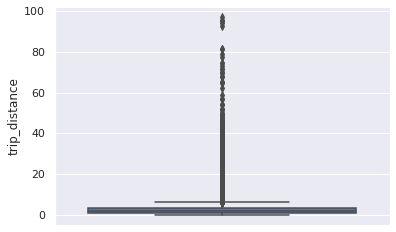

In [28]:
sns.boxplot(y=data["trip_distance"])

<AxesSubplot:ylabel='trip_distance'>

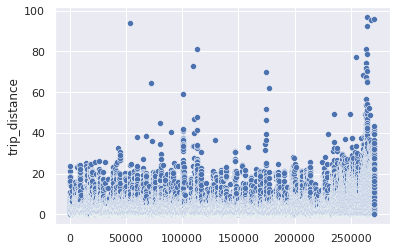

In [29]:
sns.scatterplot(x=range(data["trip_distance"].size), y=data["trip_distance"])

On observe encore beaucoup de points supérieurs à 75% des autres sur la boite à moustache mais on choisit de les garder pour l'instant. 
 
On observera l'effet de la standardisation, du trimming ou de transformation non linéaire des données lors de la phase de
modélisation et l'effet de leur absence ou non sur l'amélioration de nos modèles.

Observons la distribution de `total_amount` :

In [30]:
data["total_amount"].describe()

count    270926.000000
mean         15.768029
std          11.725814
min        -244.300000
25%           9.800000
50%          12.800000
75%          17.780000
max         700.300000
Name: total_amount, dtype: float64

On observe des valeurs négatives, ce qui est impossible. On les retire donc :

In [31]:
data = data[data["total_amount"] > 0]

<AxesSubplot:ylabel='total_amount'>

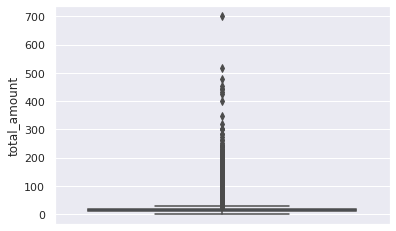

In [32]:
sns.boxplot(y=data["total_amount"])

<AxesSubplot:ylabel='total_amount'>

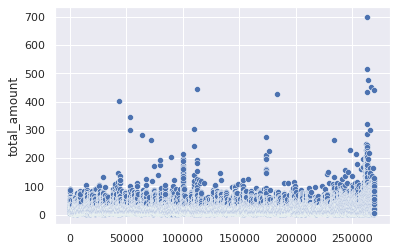

In [33]:
sns.scatterplot(x=range(data["total_amount"].size), y=data["total_amount"])

De même on observe encore beaucoup de valeurs atypiques que l'on garde en attente de standardisation, trimming ou de transformation non linéaire durant la phase de modélisation.


In [34]:
data.shape

(269584, 12)

On a désormais un dataset composé de 269 598 individus purgé des valeurs aberrantes, on peut passer à la phase d'analyse exploratoire.

On exporte le dataset nettoyé :

In [35]:
data.to_csv("../data/cleaned_dataset.csv", index=False)